## State Estimation in the Budyko-Sellers energy balance model using algorithmic differentiation in JAX
This notebook runs the Budyko-Sellers 1-D energy balance model and uses its gradient to reduce the cost function J, which represents the mismatch between zonal mean temperature from NCEP and the model.

We explore how the state estimation changes when we modify the number of controls and the uncertainties associated to them. 

* We will solve for 1 contol (albedo) and 2 controls (albedo and emissivity).
* Explore how non-dimensionalizing the inital controls helps the assimilation and provides final control values that agree better with physics and expected values.

References:

Notes on the Budyko-Sellers Model

Notes on L-BFGS implementation

Acknowledgements to Shreyas Gaikwad and Ian Fenty for providing the Fortran code which was adapted for this notebook.


In [1]:
!pip install jax jaxlib

  Using cached jax-0.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.6.1-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached jax-0.6.1-py3-none-any.whl (2.4 MB)
Using cached jaxlib-0.6.1-cp312-cp312-manylinux2014_x86_64.whl (89.1 MB)
Using cached ml_dtypes-0.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)


In [87]:
import numpy as np
import sys
from functools import partial
import netCDF4 as nc
import matplotlib.pyplot as plt

# Jax specific imports
import jax.numpy as jnp
from jax import grad, lax,jit
from functools import partial

### Step 0: Set up the model grid and read in NCEP temperature data

We will build a grid that spans from -90 to 90 degrees latitude with N=100 grid points.

Then we read in zonal mean NCEP surface temperature data from the NCEP reanalysis which will be our target. We will add some noise to that temperature vector and use it as our initial guess for the model (think of this as the output from the free running forward model).

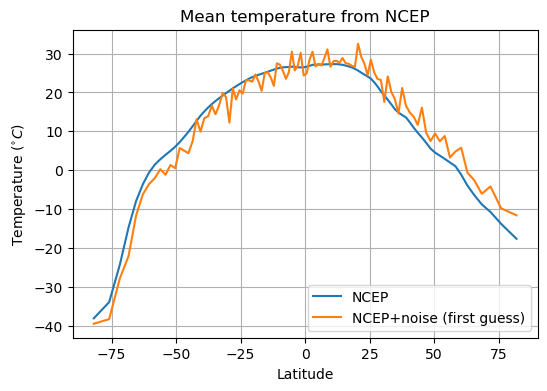

In [88]:
# Let's set up our grid
N = 100 # number of grid points
XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
LAT = jnp.arcsin(X) * 180.0 / jnp.pi
DX = X[1] - X[0]

## Import NCEP temperature, get zonal mean and extrapolate to grid size
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = nc.Dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc" )
lat_ncep = ncep_Ts.variables['lat']; lon_ncep = ncep_Ts.variables['lon']
Ts_ncep_annual = np.mean(ncep_Ts.variables['skt'][:], axis=(0,2) )
Ts_annual_interp = np.interp(LAT,np.array(lat_ncep[::-1]),Ts_ncep_annual[::-1])

# Initial guess 
Ts_with_noise = Ts_annual_interp + np.random.randn(N)*2 + 5*X

fig, ax = plt.subplots(1,1, sharex=True, figsize=(6,4))
ax.set_title('Mean temperature from NCEP')
ax.plot(LAT, Ts_annual_interp, label='NCEP')
ax.plot(LAT, Ts_with_noise, label='NCEP+noise (first guess)')
ax.set_ylabel(r'Temperature ($^{\circ}C)$')
ax.set_xlabel('Latitude')
ax.grid()
ax.legend()

## One control: albedo

Let's optimize our state estimation using 


In [82]:
def budyko_sellers_jax_1c(XXS):
    MAX_ITER = 1000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0 

    # Initial temperature
    T_init = jnp.array(Ts_with_noise)+273.0
    
    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    alpha0 = 0.354
    alpha2 = 0.25

    def step(T, _):
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5) + 1*XXS

        FIN = SX * (1.0 - ALPHA)
        FOUT = EPSILON * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = DIFF * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return T_new, ALPHA

    T_final, _ = lax.scan(step, T_init, None, length=MAX_ITER)
    ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5) + 1*XXS
      
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2))/N
    return J,T_final,ALPHA

def cost_fxn_1c(XXS):
    J,_,_ = budyko_sellers_jax_1c(XXS)
    return J

In [67]:
grad_J = grad(cost_fxn_1c)
XXS_1c = jnp.zeros(N)
dJ_dXXS_1c = grad_J(XXS_1c) 
# grad_J?

In [73]:
## gradient descent
XXS_1c = jnp.zeros(N)
ETA = 10
max_iter = 400
#J1c_old = 10000 # Something above threshold to initialize J1c in while loop
J1c = 900
i = 0
while((J1c > 0.5) & (i < max_iter)):
    #J1c_old = J1c
    J1c, T1c, alpha1c = budyko_sellers_jax_1c(XXS_1c)
    g = grad_J(XXS_1c)
    print(f'Cost function at step {i}: {J1c}')
    XXS_1c = XXS_1c - ETA*g
    i = i+1

Cost function at step 0: 1.1240110397338867
Cost function at step 1: 1.0782917737960815
Cost function at step 2: 1.0336319208145142
Cost function at step 3: 0.9905925989151001
Cost function at step 4: 0.9496566653251648
Cost function at step 5: 0.9111443161964417
Cost function at step 6: 0.8752828240394592
Cost function at step 7: 0.8421579599380493
Cost function at step 8: 0.8117601275444031
Cost function at step 9: 0.7840118408203125
Cost function at step 10: 0.7587683796882629
Cost function at step 11: 0.7358630299568176
Cost function at step 12: 0.7151121497154236
Cost function at step 13: 0.6963164806365967
Cost function at step 14: 0.6792849898338318
Cost function at step 15: 0.6638498902320862
Cost function at step 16: 0.6498382091522217
Cost function at step 17: 0.6371064186096191
Cost function at step 18: 0.6255149245262146
Cost function at step 19: 0.6149477958679199
Cost function at step 20: 0.6052970886230469
Cost function at step 21: 0.5964710712432861
Cost function at ste

Text(0.5, 0, 'Latitude')

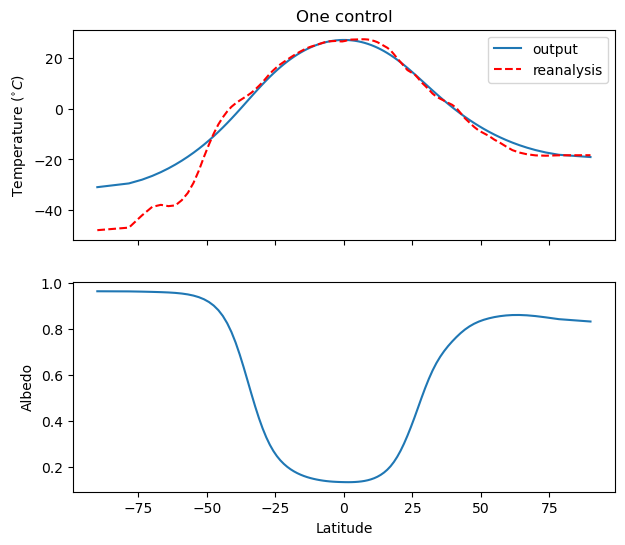

In [74]:
lat = np.arcsin(np.linspace(-1.0, 1.0, 100)) * 180.0 / jnp.pi
T_ncep = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

fig, (ax,ax2) = plt.subplots(2,1, sharex=True, figsize=(7,6))
ax.set_title('One control')
ax.plot(lat, T1c-273)
ax.plot(lat,T_ncep,'--r')
ax.legend(('output','reanalysis'), bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha1c)
ax2.set_ylabel('Albedo')
ax2.set_xlabel('Latitude')

## Two controls: albedo and emissivity

In [75]:
def budyko_sellers_jax_2c(XXS):
    MAX_ITER = 1000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    TARGET_DT = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0 

    # Initial temperature
    #T_init = 288.0 + 60.0 * (1.0 - X**2) - 20.0
    T_init = jnp.array(Ts_with_noise)+273.0
    
    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    alpha0 = 0.354
    alpha2 = 0.25

    def step(T, _):
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)+1*XXS[:N]
        #ALPHA = jnp.log(ALPHA / (1.0 - ALPHA)) + 1*XXS[:N]
        #ALPHA = 1.0 / (1.0 + jnp.exp(-ALPHA))

        #emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) + 1*XXS[N:]
        emiss = EPSILON + 1*XXS[N:]#1.0/(1.0+ jnp.exp(emiss_logit))

        FIN = SX * (1.0 - ALPHA)
        FOUT = (emiss) * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = DIFF * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return T_new, ALPHA

    T_final, _ = lax.scan(step, T_init, None, length=MAX_ITER)
    #alpha_raw = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
    #logits = jnp.log(alpha_raw / (1.0 - alpha_raw)) + 1*XXS[:N]
    #ALPHA = 1.0 / (1.0 + jnp.exp(-logits))
    #emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) + 1.0*XXS[N:]
    #emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))
    
    ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)+1*XXS[:N]
    emiss = EPSILON + 1*XXS[N:]#1.0/(1.0+ jnp.exp(emiss_logit))

    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2))/N
    return J,T_final,ALPHA,emiss

def cost_fxn_2c(XXS):
    J,_,_,_ = budyko_sellers_jax_2c(XXS)
    return J

In [76]:
grad_J = grad(cost_fxn_2c)
XXS = jnp.zeros(2*N)
dJ_dXXS = grad_J(XXS) 
# grad_J?

In [79]:
## gradient descent
XXS = jnp.zeros(2*N)

a = 1
max_iter = 400
J = 1000
i = 0
while((J > 0.5) & (i < max_iter)):
    J,T,alpha,emiss = budyko_sellers_jax_2c(XXS)
    g = grad_J(XXS)
    print(f'Cost function at step {i}: {J}')
    XXS = XXS - a*g
    i = i+1

Cost function at step 0: 1.1240112781524658
Cost function at step 1: 0.9442978501319885
Cost function at step 2: 0.7891073822975159
Cost function at step 3: 0.6532646417617798
Cost function at step 4: 0.5345837473869324
Cost function at step 5: 0.43396827578544617


Text(0.5, 0, 'Latitude')

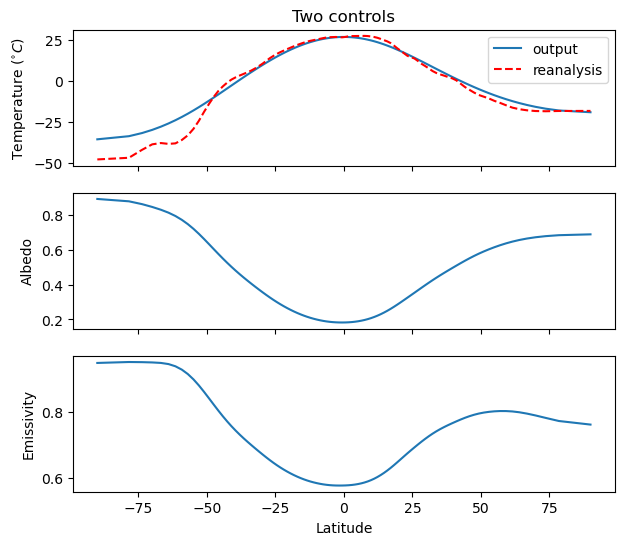

In [80]:
import matplotlib.pyplot as plt
lat = np.arcsin(np.linspace(-1.0, 1.0, 100)) * 180.0 / jnp.pi
T_ncep = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))

fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two controls')
ax.plot(lat, T-273)
ax.plot(lat,T_ncep,'--r')
ax.legend(('output','reanalysis'), bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha)
ax2.set_ylabel('Albedo')

ax3.plot(lat, emiss)
ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')

## Normalizing control vector

Right now albedo and emissivity have equal "weights" within the control vector although their typical magnitudes are different. We can normalize the control vector by dividing it by an uncertainties vector that will have the value of the uncertainties for each control (say the typical magnitude of their variations).

let's do alpha=0.1
and epsilon=0.001

In [81]:
def cost_norm(u, UNCER):
    # Map normalized u → physical controls XXS
    XXS = u * UNCER
    J, _, _, _ = budyko_sellers_jax_2c(XXS)
    return J

unc_alpha = [1,0.1,0.1,0.5]
unc_emiss = [1,0.1,0.01,0.1]
T_norm = jnp.zeros((len(unc_alpha),N))
alpha_norm = jnp.zeros((len(unc_alpha),N))
emiss_norm = jnp.zeros((len(unc_alpha),N))
J_norm = jnp.zeros(len(unc_alpha))

for Dalpha, Demiss, ii in zip(unc_alpha, unc_emiss, range(3)):
    # Initialize normalized parameters
    u = jnp.zeros(2 * N)
    eta = 1
    max_iter = 500
    
    # Uncertainties for normalization
    UNCER = jnp.concatenate([Dalpha * jnp.ones(N), Demiss * jnp.ones(N)])
    # Gradient of the normalized cost
    grad_u = grad(lambda u: cost_norm(u, UNCER))
    
    for i in range(max_iter):
        J_val = cost_norm(u, UNCER)
        g = grad_u(u)
        if J_val < 0.5:
            break
        u = u - eta * g
    print(f"Delta alpha = {Dalpha:.5f} and Delta epsilon = {Demiss:.5f}")
    print(f"Step {i:03d}: J = {J_val:.6f}, ||grad|| = {jnp.linalg.norm(g):.2e}")
         
    # Recover optimal physical controls
    XXS_opt = u * UNCER
    J_n, T_n, alpha_n, emiss_n = budyko_sellers_jax_2c(XXS_opt)
    J_norm = J_norm.at[ii].set(J_n)
    T_norm = T_norm.at[ii,:].set(T_n)
    alpha_norm = alpha_norm.at[ii,:].set(alpha_n)
    emiss_norm = emiss_norm.at[ii,:].set(emiss_n)

Delta alpha = 1.00000 and Delta epsilon = 1.00000
Step 005: J = 0.433968, ||grad|| = 2.93e-01
Delta alpha = 0.10000 and Delta epsilon = 0.10000
Step 442: J = 0.499783, ||grad|| = 3.18e-02
Delta alpha = 0.10000 and Delta epsilon = 0.01000
Step 499: J = 0.758893, ||grad|| = 2.60e-02


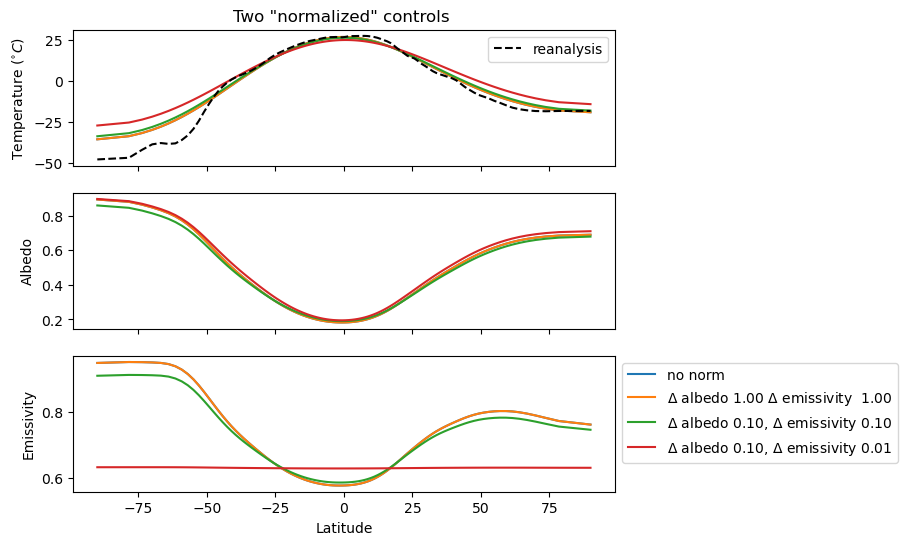

In [83]:
fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two "normalized" controls ')
ax.plot(lat, T-273)
ax.plot(lat, T_norm[0,:]-273)
ax.plot(lat, T_norm[1,:]-273)
ax.plot(lat, T_norm[2,:]-273)

ax.plot(lat,T_ncep,'--k', label='reanalysis')
ax.legend( bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha)
ax2.plot(lat, alpha_norm[0,:])
ax2.plot(lat, alpha_norm[1,:])
ax2.plot(lat, alpha_norm[2,:])
ax2.set_ylabel('Albedo')

ax3.plot(lat, emiss, label='no norm')
ax3.plot(lat, emiss_norm[0,:], label=(r'$\Delta$ albedo %1.2f $\Delta$ emissivity  %1.2f' %(unc_alpha[0],unc_emiss[0])))
ax3.plot(lat, emiss_norm[1,:], label=r'$\Delta$ albedo %1.2f, $\Delta$ emissivity %1.2f' %(unc_alpha[1],unc_emiss[1]))
ax3.plot(lat, emiss_norm[2,:], label=r'$\Delta$ albedo %1.2f, $\Delta$ emissivity %1.2f' %(unc_alpha[2],unc_emiss[2]))

ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')
ax3.legend(bbox_to_anchor=(1,1))

What if we allow uncertainty to vary with latitude. For example, we would expect albedo to vary more where we have regions of ice/snow that melt (higher uncertainies), vs regions where there never is ice/snow (lower uncertainties)?

In [85]:
T_norm2 = jnp.zeros((N))
alpha_norm2 = jnp.zeros((N))
emiss_norm2 = jnp.zeros((N))

# Initialize normalized parameters
u = jnp.zeros(2 * N)
eta = 1
max_iter = 500

# Uncertainties for normalization
Demiss = 0.01
Dalpha1 = 0.1
Dalpha2 = 0.9
Dalpha_var = Dalpha2*jnp.ones(N)
Dalpha_var = Dalpha_var.at[10:-10].set(Dalpha1)

UNCER = jnp.concatenate([Dalpha_var, Demiss * jnp.ones(N)])

# Gradient of the normalized cost
grad_u = grad(lambda u: cost_norm(u, UNCER))

for i in range(max_iter):
    J_val = cost_norm(u, UNCER)
    g = grad_u(u)
    if J_val < 0.5:
        break
    u = u - eta * g
print(f"Delta alpha = {Dalpha:.5f} and Delta epsilon = {Demiss:.5f}")
print(f"Step {i:03d}: J = {J_val:.6f}, ||grad|| = {jnp.linalg.norm(g):.2e}")
     
# Recover optimal physical controls
XXS_opt = u * UNCER
J_n, T_n, alpha_n, emiss_n = budyko_sellers_jax_2c(XXS_opt)
J_norm2 = J_n
T_norm2 = T_norm2.at[:].set(T_n)
alpha_norm2 = alpha_norm2.at[:].set(alpha_n)
emiss_norm2 = emiss_norm2.at[:].set(emiss_n)

Delta alpha = 0.10000 and Delta epsilon = 0.01000
Step 021: J = 0.494334, ||grad|| = 1.41e-01


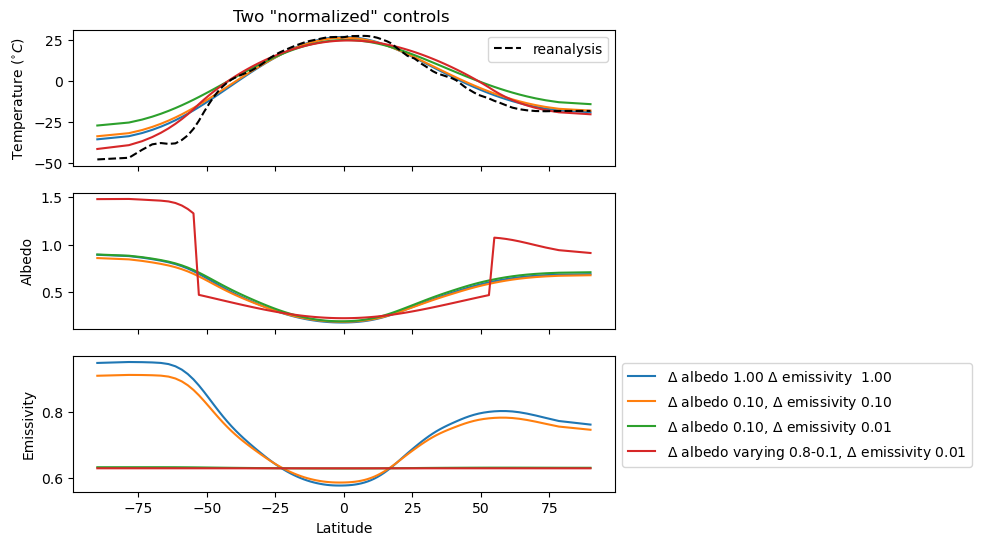

In [86]:
fig, (ax,ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(7,6))
ax.set_title('Two "normalized" controls ')
ax.plot(lat, T_norm[0,:]-273)
ax.plot(lat, T_norm[1,:]-273)
ax.plot(lat, T_norm[2,:]-273)
ax.plot(lat, T_norm2[:]-273)

ax.plot(lat,T_ncep,'--k', label='reanalysis')
ax.legend( bbox_to_anchor=(1,1))
ax.set_ylabel(r'Temperature ($^{\circ}C)$')

ax2.plot(lat, alpha_norm[0,:])
ax2.plot(lat, alpha_norm[1,:])
ax2.plot(lat, alpha_norm[2,:])
ax2.plot(lat, alpha_norm2[:])
ax2.set_ylabel('Albedo')

ax3.plot(lat, emiss_norm[0,:], label=(r'$\Delta$ albedo %1.2f $\Delta$ emissivity  %1.2f' %(unc_alpha[0],unc_emiss[0])))
ax3.plot(lat, emiss_norm[1,:], label=r'$\Delta$ albedo %1.2f, $\Delta$ emissivity %1.2f' %(unc_alpha[1],unc_emiss[1]))
ax3.plot(lat, emiss_norm[2,:], label=r'$\Delta$ albedo %1.2f, $\Delta$ emissivity %1.2f' %(unc_alpha[2],unc_emiss[2]))
ax3.plot(lat, emiss_norm2[:], label=r'$\Delta$ albedo varying 0.8-0.1, $\Delta$ emissivity %1.2f' %(unc_emiss[2]) )

ax3.set_ylabel('Emissivity')
ax3.set_xlabel('Latitude')
ax3.legend(bbox_to_anchor=(1,1))

For Earth as a whole (i.e. the “planetary” emitter), you don’t behave like a perfect blackbody. To match the outgoing long-wave radiation at a surface temperature of 288 K (15 °C), you need an effective emissivity of roughly 0.61. This is the factor ε in
F=ε σ T4
F=εσT4

that brings the Stefan–Boltzmann flux into balance with absorbed solar energy.
Dutton Institute
Wikipedia

At the surface itself, broadband long-wave emissivities are much higher—most natural materials emit very efficiently in the thermal infrared. Observations in the 8–13 μm “atmospheric window” give:

    Surface emissivity ranges from about 0.65 (bare desert) up to 0.99 (wet or vegetated regions), with most land and ocean surfaces above 0.9, yielding a global average near 0.95.
    Wikipedia

    Ocean emissivity specifically is measured at 0.96–0.99 over 1–100 μm, and ~0.98–0.99 in the 8–14 μm window used for sea-surface-temperature retrieval.

Here are the key “albedo” numbers you’ll often see for Earth:

    Planetary (Bond) albedo
    The fraction of all incoming solar radiation that Earth scatters back to space.
    AEarth≈0.29–0.31
    AEarth​≈0.29–0.31

    – NASA/UCAR report an average of about 31 %
    Center for Science Education

    – Wikipedia (Bond albedo) lists 0.294
    Wikipedia

    Surface albedos (visible/near-IR, vary strongly by land-cover)
    Wikipedia
    :
    Surface type	Typical albedo
    Open ocean	0.06
    Conifer forest (summer)	0.08 – 0.15
    Deciduous forest	0.15 – 0.18
    Grassland	∼0.25
    Bare soil	∼0.17
    Desert sand	∼0.40
    Fresh concrete	∼0.55
    Sea ice	0.50 – 0.70
    Fresh snow	0.80 – 0.85

    Atmospheric/cloud albedo
    Clouds boost Earth’s overall reflectivity; depending on type, cloud-top albedo ranges up to 0.8, and with ~50 % cloud cover contributes heavily to the planetary average
    Wikipedia
    .

Which albedo to use in an EBM?

    For a global 1-D energy balance model you normally set
    Ap≈0.30
    Ap​≈0.30

    as the planetary albedo (incorporating land, ocean, ice and clouds).

    If you want to resolve latitude bands, you’d assign each band its surface albedo (as above) plus a latitude

    -dependent cloud fraction to approximate the total reflectance.



Uncertainties
| albedo| emissivity|notes|
|:-:|:-:|:-:|
|1|1|Step 014: J = 49.999809, grad = 9.87e-01, eta=1|
|0.1|0.1|Step 131: J = 49.982227, grad = 4.64e-02 but did eta=10|
|0.1|0.01||